In [1]:
import rasterio
import torch
from terratorch.registry import BACKBONE_REGISTRY
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
file_path = '/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_7496_LabelHand.tif'  # Replace with your actual file path

with rasterio.open(file_path) as src:
    print("Number of bands:", src.count)
    print("Height (pixels):", src.height)
    print("Width (pixels):", src.width)
    print("Shape (bands, height, width):", (src.count, src.height, src.width))


/mnt/venv888/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of bands: 1
Height (pixels): 512
Width (pixels): 512
Shape (bands, height, width): (1, 512, 512)


In [2]:
import os

label_dir = '/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand/'
label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.tif')]
print("Number of label files:", len(label_files))
print("Example file:", label_files[0])


Number of label files: 446
Example file: /mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand/India_1050276_LabelHand.tif


Label shape: (512, 512)
Unique values in mask: {np.int16(0), np.int16(1), np.int16(-1)}


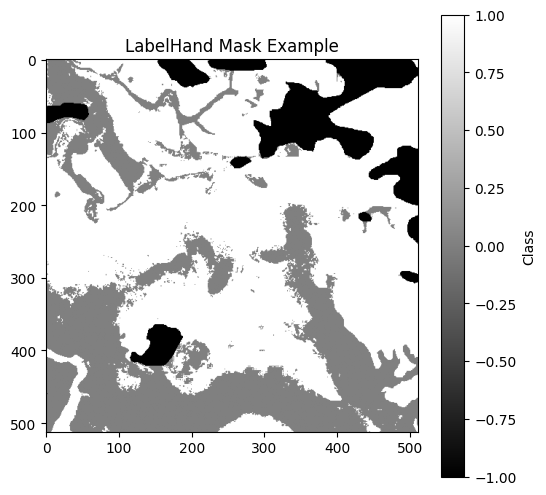

In [3]:
import rasterio
import matplotlib.pyplot as plt

# Read the first label file
with rasterio.open(label_files[1]) as src:
    label = src.read(1)  # Read first (and only) band
    print("Label shape:", label.shape)
    print("Unique values in mask:", set(label.flatten()))

# Display the label image
plt.figure(figsize=(6,6))
plt.imshow(label, cmap='gray')
plt.title('LabelHand Mask Example')
plt.colorbar(label='Class')
plt.show()


In [4]:
import csv
import os
def read_prithvi_bands_from_dir(dir_path,mask_dir_path ,csv_path):
    images = []
    masks = []

    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) >= 2:
                input_rel, mask_rel = row[0], row[1]
                input_rel = input_rel.replace("S1Hand", "S2Hand")


                input_full = os.path.join(dir_path, input_rel)
                mask_full = os.path.join(mask_dir_path, mask_rel)
                with rasterio.open(input_full) as src:
                    img = src.read([2, 3, 4, 9, 11, 12])  # 1-based band indices
                    img = img / 10000.0  # Normalize reflectance if needed
                    images.append(img)
                with rasterio.open(mask_full) as src:
                    mask = src.read(1)
                    mask = (mask).astype(np.int64)  
                    masks.append(mask)

    if images:
        print('Number of images read:', len(images))
        print('Shape of first image:', images[0].shape)  # (6, height, width)
    else:
        print('No images found in directory')
    if masks:
        print('Number of masks read:', len(masks))
        print('Shape of first mask:', masks[0].shape)  # (height, width)
        print('Unique values in first mask:', np.unique(masks[0]))  # Should show 0, 1, and possibly -1
    else:
        print('No masks found in directory')
    return images, masks

In [5]:
img_path='/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/S2Hand'
masks_path='/mnt/ADV_VISION/Dataset/v1.1/data/flood_events/HandLabeled/LabelHand'
train_img, train_mask = read_prithvi_bands_from_dir(img_path, masks_path,'/mnt/ADV_VISION/v1.1C/splits/flood_handlabeled/flood_train_data.csv')
val_img, val_mask = read_prithvi_bands_from_dir(img_path, masks_path,'/mnt/ADV_VISION/v1.1C/splits/flood_handlabeled/flood_valid_data.csv')
test_img, test_mask = read_prithvi_bands_from_dir(img_path, masks_path,'/mnt/ADV_VISION/v1.1C/splits/flood_handlabeled/flood_test_data.csv')

Number of images read: 252
Shape of first image: (6, 512, 512)
Number of masks read: 252
Shape of first mask: (512, 512)
Unique values in first mask: [-1  0  1]
Number of images read: 89
Shape of first image: (6, 512, 512)
Number of masks read: 89
Shape of first mask: (512, 512)
Unique values in first mask: [-1]
Number of images read: 90
Shape of first image: (6, 512, 512)
Number of masks read: 90
Shape of first mask: (512, 512)
Unique values in first mask: [-1  0  1]


In [6]:
import matplotlib.pyplot as plt

def plot_sensitivity(miou_histories, labels):
    """
    Plots mIoU curves for different experimental conditions.
    Args:
        miou_histories: List of lists, each containing mIoU values per epoch.
        labels: List of strings describing each experiment (e.g., '100% Data', '50% Data').
    """
    for miou, label in zip(miou_histories, labels):
        plt.plot(miou, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Validation mIoU')
    plt.title('Sensitivity Analysis: mIoU vs Training Data Amount')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
import torch
import torch.nn as nn
import numpy as np
from terratorch.registry import FULL_MODEL_REGISTRY


def compute_iou(output, target):
    # print("Output shape:", output.shape)
    # print("Target shape:", target.shape)
    output = output.flatten()
    target = target.flatten()
    # No ignore mask needed!
    intersection = torch.sum(output == target)
    union = output.numel()  # All pixels are valid
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou


def train_model(
    train_imgs, train_masks, 
    val_imgs, val_masks, 
    model_class, 
    num_classes=3, 
    epochs=50, 
    lr=1e-3, 
    loss_fn=None, 
    optimizer_class=None,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FULL_MODEL_REGISTRY.build(
        "prithvi_eo_v2_300_mae",
        pretrained=True,
        pretrained_cfg_name="Prithvi-EO-V2-300M-TL-Sen1Floods11.pt",
        checkpoint_path="/mnt/ADV_VISION/Prithvi-EO-2.0-300M-TL-Sen1Floods11"
    ).to("cuda")
    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    if optimizer_class is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr)
    
    miou_history = []
    best_miou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for img, mask in zip(train_imgs, train_masks):
            inputs = torch.tensor(img, device=device).float().unsqueeze(0)  # [1, C, H, W]
            targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)  # [1, H, W]
            # preds = torch.argmax(targets, dim=1)  # Shape: [batch_size, height, width]
            unique_classes = torch.unique(targets)
            # print(unique_classes)
            optimizer.zero_grad()

            output = model(inputs)

            # Handle model output: assume (loss_dict, logits) format
            if isinstance(output, tuple):
                if isinstance(output[1], torch.Tensor):
                    logits = output[1]
                else:
                    raise TypeError(f"[ERROR] Expected Tensor in tuple[1], got {type(output[1])}")
            elif isinstance(output, dict):
                logits = output.get("logits") or output.get("out") or next(iter(output.values()))
            else:
                logits = output

            # Final check
            if not isinstance(logits, torch.Tensor):
                raise TypeError(f"[ERROR] Expected Tensor for logits, got {type(logits)}")




            loss = loss_fn(logits, targets)
            # print(loss.item())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # print(train_loss)
        # print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_imgs):.4f}")
        
        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for img, mask in zip(val_imgs, val_masks):
                inputs = torch.tensor(img, device=device).float().unsqueeze(0)
                targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)
                output = model(inputs)

                # Handle model output: assume (loss_dict, logits) format
                if isinstance(output, tuple):
                    if isinstance(output[1], torch.Tensor):
                        logits = output[1]
                    else:
                        raise TypeError(f"[ERROR] Expected Tensor in tuple[1], got {type(output[1])}")
                elif isinstance(output, dict):
                    logits = output.get("logits") or output.get("out") or next(iter(output.values()))
                else:
                    logits = output

                # Final check
                if not isinstance(logits, torch.Tensor):
                    raise TypeError(f"[ERROR] Expected Tensor for logits, got {type(logits)}")



                loss = loss_fn(logits, targets)
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)  # [1, H, W]
                
                val_miou += compute_iou(preds.cpu(), targets.cpu())
        val_miou /= len(val_imgs)
        miou_history.append(val_miou)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_imgs):.4f} | "
              f"Val Loss: {val_loss/len(val_imgs):.4f} | Val mIoU: {val_miou:.4f}")
        
        # Save best model
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  Saved new best model with mIoU {best_miou:.4f}")
    
    return model, miou_history


In [16]:
def compute_iou(output, target):
    output = output.flatten()
    target = target.flatten()
    
    # Mask for classes 1 and 2 in TARGET (ignore 0)
    mask = (target == 1) | (target == 2)
    
    # Apply mask to both tensors
    output_filtered = output[mask]
    target_filtered = target[mask]
    
    intersection = torch.sum(output_filtered == target_filtered)
    union = output_filtered.numel()  # Total masked pixels
    
    return (intersection + 1e-7) / (union + 1e-7)
def train_model(
    train_imgs, train_masks, 
    val_imgs, val_masks, 
    test_imgs, test_masks,  # NEW: test data
    model_class, 
    num_classes=3, 
    epochs=50, 
    lr=1e-3, 
    loss_fn=None, 
    optimizer_class=None,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FULL_MODEL_REGISTRY.build(
        "prithvi_eo_v2_300_mae",
        pretrained=True,
        pretrained_cfg_name="Prithvi-EO-V2-300M-TL-Sen1Floods11.pt",
        checkpoint_path="/mnt/ADV_VISION/Prithvi-EO-2.0-300M-TL-Sen1Floods11"
    ).to("cuda")
    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    if optimizer_class is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr)
    
    miou_history = []
    best_miou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for img, mask in zip(train_imgs, train_masks):
            inputs = torch.tensor(img, device=device).float().unsqueeze(0)
            targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)

            optimizer.zero_grad()
            output = model(inputs)
            if isinstance(output, tuple):
                if isinstance(output[1], torch.Tensor):
                    logits = output[1]

            loss = loss_fn(logits, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for img, mask in zip(val_imgs, val_masks):
                inputs = torch.tensor(img, device=device).float().unsqueeze(0)
                targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)
                output = model(inputs)
                if isinstance(output, tuple):
                    if isinstance(output[1], torch.Tensor):
                        logits = output[1]
                
                loss = loss_fn(logits, targets)
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                val_miou += compute_iou(preds.cpu(), targets.cpu())

        val_miou /= len(val_imgs)
        miou_history.append(val_miou)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_imgs):.4f} | "
              f"Val Loss: {val_loss/len(val_imgs):.4f} | Val mIoU: {val_miou:.4f}")
        
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  Saved new best model with mIoU {best_miou:.4f}")

    # After training, evaluate on test set
    test_miou = 0.0
    with torch.no_grad():
        for img, mask in zip(test_imgs, test_masks):
            inputs = torch.tensor(img, device=device).float().unsqueeze(0)
            targets = torch.tensor(mask+1, device=device).long().unsqueeze(0)
            output = model(inputs)
            if isinstance(output, tuple):
                if isinstance(output[1], torch.Tensor):
                    logits = output[1]
            preds = torch.argmax(logits, dim=1)
            test_miou += compute_iou(preds.cpu(), targets.cpu())

    test_miou /= len(test_imgs)
    print(f"\n✅ Final Test mIoU: {test_miou:.4f}")

    return model, miou_history, test_miou


INFO:terratorch.models.backbones.prithvi_vit:model_bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].Pretrained patch_embed layer may be misaligned with current bands
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
INFO:terratorch.models.backbones.prithvi_vit:model_bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_N


🔍 Training with 100% of data (252 samples)...


INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


Epoch 1/50 | Train Loss: 0.7331 | Val Loss: 0.7544 | Val mIoU: 0.8896
  Saved new best model with mIoU 0.8896
Epoch 2/50 | Train Loss: 0.6836 | Val Loss: 0.7633 | Val mIoU: 0.8896
Epoch 3/50 | Train Loss: 0.6786 | Val Loss: 0.7653 | Val mIoU: 0.8896
Epoch 4/50 | Train Loss: 0.6757 | Val Loss: 0.7618 | Val mIoU: 0.8896
Epoch 5/50 | Train Loss: 0.6747 | Val Loss: 0.7603 | Val mIoU: 0.8896
Epoch 6/50 | Train Loss: 0.6743 | Val Loss: 0.7589 | Val mIoU: 0.8896
Epoch 7/50 | Train Loss: 0.6742 | Val Loss: 0.7573 | Val mIoU: 0.8896
Epoch 8/50 | Train Loss: 0.6742 | Val Loss: 0.7544 | Val mIoU: 0.8896
Epoch 9/50 | Train Loss: 0.6740 | Val Loss: 0.7533 | Val mIoU: 0.8896
Epoch 10/50 | Train Loss: 0.6742 | Val Loss: 0.7524 | Val mIoU: 0.8896
Epoch 11/50 | Train Loss: 0.7032 | Val Loss: 0.7472 | Val mIoU: 0.8896
Epoch 12/50 | Train Loss: 0.6820 | Val Loss: 0.7626 | Val mIoU: 0.8896
Epoch 13/50 | Train Loss: 0.6712 | Val Loss: 0.7593 | Val mIoU: 0.8896
Epoch 14/50 | Train Loss: 0.6740 | Val Loss: 0

INFO:terratorch.models.backbones.prithvi_vit:model_bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].Pretrained patch_embed layer may be misaligned with current bands



✅ Final Test mIoU: 0.8664

🔍 Training with 50% of data (126 samples)...


INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


Epoch 1/50 | Train Loss: 0.9712 | Val Loss: 0.7563 | Val mIoU: 0.8896
  Saved new best model with mIoU 0.8896
Epoch 2/50 | Train Loss: 0.8222 | Val Loss: 0.7207 | Val mIoU: 0.8896
Epoch 3/50 | Train Loss: 0.8212 | Val Loss: 0.7143 | Val mIoU: 0.8896
Epoch 4/50 | Train Loss: 0.8207 | Val Loss: 0.7036 | Val mIoU: 0.8896
Epoch 5/50 | Train Loss: 0.8140 | Val Loss: 0.7020 | Val mIoU: 0.8896
Epoch 6/50 | Train Loss: 0.8095 | Val Loss: 0.7002 | Val mIoU: 0.8896
Epoch 7/50 | Train Loss: 0.8081 | Val Loss: 0.6987 | Val mIoU: 0.8896
Epoch 8/50 | Train Loss: 0.8072 | Val Loss: 0.6970 | Val mIoU: 0.8896
Epoch 9/50 | Train Loss: 0.8069 | Val Loss: 0.6955 | Val mIoU: 0.8896
Epoch 10/50 | Train Loss: 0.8065 | Val Loss: 0.6934 | Val mIoU: 0.8896
Epoch 11/50 | Train Loss: 0.8070 | Val Loss: 0.6916 | Val mIoU: 0.8896
Epoch 12/50 | Train Loss: 0.8073 | Val Loss: 0.6908 | Val mIoU: 0.8896
Epoch 13/50 | Train Loss: 0.8074 | Val Loss: 0.6903 | Val mIoU: 0.8896
Epoch 14/50 | Train Loss: 0.8072 | Val Loss: 0

INFO:terratorch.models.backbones.prithvi_vit:model_bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].Pretrained patch_embed layer may be misaligned with current bands



✅ Final Test mIoU: 0.8664

🔍 Training with 25% of data (63 samples)...


INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


Epoch 1/50 | Train Loss: 0.9812 | Val Loss: 0.7084 | Val mIoU: 0.8896
  Saved new best model with mIoU 0.8896
Epoch 2/50 | Train Loss: 0.8105 | Val Loss: 0.6958 | Val mIoU: 0.8896
Epoch 3/50 | Train Loss: 0.7808 | Val Loss: 0.6931 | Val mIoU: 0.8896
Epoch 4/50 | Train Loss: 0.7818 | Val Loss: 0.6916 | Val mIoU: 0.8896
Epoch 5/50 | Train Loss: 0.7827 | Val Loss: 0.6933 | Val mIoU: 0.8896
Epoch 6/50 | Train Loss: 0.7807 | Val Loss: 0.6938 | Val mIoU: 0.8896
Epoch 7/50 | Train Loss: 0.7778 | Val Loss: 0.6955 | Val mIoU: 0.8896
Epoch 8/50 | Train Loss: 0.7768 | Val Loss: 0.6980 | Val mIoU: 0.8896
Epoch 9/50 | Train Loss: 0.7746 | Val Loss: 0.7003 | Val mIoU: 0.8896
Epoch 10/50 | Train Loss: 0.7731 | Val Loss: 0.7030 | Val mIoU: 0.8896
Epoch 11/50 | Train Loss: 0.7711 | Val Loss: 0.7053 | Val mIoU: 0.8896
Epoch 12/50 | Train Loss: 0.7687 | Val Loss: 0.7075 | Val mIoU: 0.8896
Epoch 13/50 | Train Loss: 0.7672 | Val Loss: 0.7102 | Val mIoU: 0.8896
Epoch 14/50 | Train Loss: 0.7649 | Val Loss: 0

INFO:terratorch.models.backbones.prithvi_vit:model_bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].Pretrained patch_embed layer may be misaligned with current bands



✅ Final Test mIoU: 0.8664

🔍 Training with 10% of data (25 samples)...


INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


Epoch 1/50 | Train Loss: 0.8849 | Val Loss: 0.8461 | Val mIoU: 0.8896
  Saved new best model with mIoU 0.8896
Epoch 2/50 | Train Loss: 0.8385 | Val Loss: 0.7680 | Val mIoU: 0.8896
Epoch 3/50 | Train Loss: 0.7704 | Val Loss: 0.8027 | Val mIoU: 0.8896
Epoch 4/50 | Train Loss: 0.7650 | Val Loss: 0.8088 | Val mIoU: 0.8896
Epoch 5/50 | Train Loss: 0.7197 | Val Loss: 0.8080 | Val mIoU: 0.8896
Epoch 6/50 | Train Loss: 0.6984 | Val Loss: 0.8126 | Val mIoU: 0.8896
Epoch 7/50 | Train Loss: 0.6853 | Val Loss: 0.8108 | Val mIoU: 0.8896
Epoch 8/50 | Train Loss: 0.6788 | Val Loss: 0.8067 | Val mIoU: 0.8896
Epoch 9/50 | Train Loss: 0.6756 | Val Loss: 0.8084 | Val mIoU: 0.8896
Epoch 10/50 | Train Loss: 0.6737 | Val Loss: 0.8058 | Val mIoU: 0.8896
Epoch 11/50 | Train Loss: 0.6724 | Val Loss: 0.8070 | Val mIoU: 0.8896
Epoch 12/50 | Train Loss: 0.6714 | Val Loss: 0.8051 | Val mIoU: 0.8896
Epoch 13/50 | Train Loss: 0.6715 | Val Loss: 0.8065 | Val mIoU: 0.8896
Epoch 14/50 | Train Loss: 0.6734 | Val Loss: 0

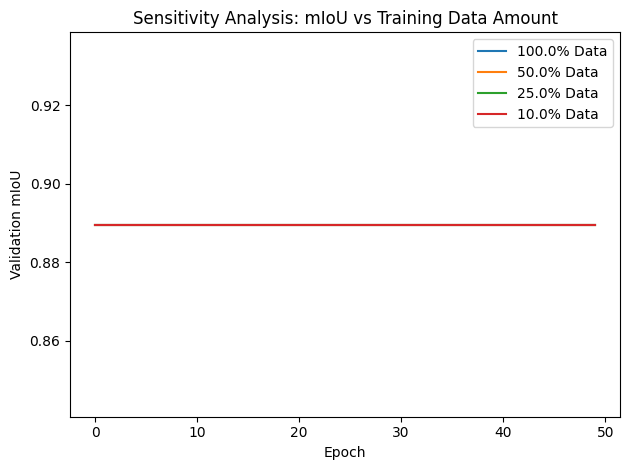


📊 Final Test mIoU Summary:
╒══════════════════════╤═════════════╕
│ Training Data Used   │   Test mIoU │
╞══════════════════════╪═════════════╡
│ 100.0% Data          │      0.8664 │
├──────────────────────┼─────────────┤
│ 50.0% Data           │      0.8664 │
├──────────────────────┼─────────────┤
│ 25.0% Data           │      0.8664 │
├──────────────────────┼─────────────┤
│ 10.0% Data           │      0.8664 │
╘══════════════════════╧═════════════╛


In [17]:
from tabulate import tabulate

def run_sensitivity_analysis(full_train_data, full_train_masks, val_data, val_masks, test_data, test_masks):
    # Test different labeled data amounts
    data_fractions = [1.0, 0.5, 0.25, 0.1]
    histories = []
    test_mious = []
    from terratorch.registry import FULL_MODEL_REGISTRY

    model = FULL_MODEL_REGISTRY.build(
        "prithvi_eo_v2_300_mae",
        pretrained=True,
        pretrained_cfg_name="Prithvi-EO-V2-300M-TL-Sen1Floods11.pt",
        checkpoint_path="/mnt/ADV_VISION/Prithvi-EO-2.0-300M-TL-Sen1Floods11"
    )
    model.to("cuda")
    for frac in data_fractions:
        # Subsample training data
        n_samples = int(len(full_train_data) * frac)
        train_subset = full_train_data[:n_samples]
        mask_subset = full_train_masks[:n_samples]
        
        print(f"\n🔍 Training with {frac*100:.0f}% of data ({n_samples} samples)...")
        
        # Train with current data fraction
        model, history, test_miou = train_model(
            train_subset, mask_subset,
            val_data, val_masks,
            test_data, test_masks,
            model_class=model
        )
        
        histories.append((f"{frac*100}% Data", history))
        test_mious.append(test_miou)
    
    # Plot mIoU sensitivity on validation data
    plot_sensitivity([h[1] for h in histories], [h[0] for h in histories])

    # Pretty print test mIoUs
    table = [(label, f"{miou:.4f}") for label, miou in zip([h[0] for h in histories], test_mious)]
    print("\n📊 Final Test mIoU Summary:")
    print(tabulate(table, headers=["Training Data Used", "Test mIoU"], tablefmt="fancy_grid"))
run_sensitivity_analysis(train_img, train_mask, val_img, val_mask,test_img, test_mask)
